In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from nas_wot import score
from MNISTConvNet import MNISTConvNet
from early_stopping import EarlyStopping

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [28]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [29]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                        name='learning_rate')

dim_num_conv_layers = Integer(low=1, high=3, name='num_conv_layers')

dim_num_fc_units = Integer(low=5, high=512, name='num_fc_units')

dim_dropout_rate = Real(low=1e-5, high=1e-2, prior='log-uniform',
                        name='dropout_rate')

dimensions = [dim_learning_rate,
              dim_num_conv_layers,
              dim_num_fc_units,
              dim_dropout_rate]

default_parameters = [1e-5, 1, 16, 1e-4]

In [30]:
def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # choose the training and test datasets
    train_data = torchvision.datasets.MNIST(root='./data/MNIST', 
                                train=True,
                                download=True, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(0, 1)
                               ]))
    
    test_data = torchvision.datasets.MNIST(root='./data/MNIST',
                               train=False,
                               download=True,
                               transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(0, 1)
                               ]))

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

In [49]:
def plot_early_stopping(train_loss, valid_loss):
    """
    train_loss = avg_train_losses : List
    valid_loss = avg_valid_losses : List
    """
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1), train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1), valid_loss, label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

In [32]:
def train(model, lr, num_epoch, train_loader, valid_loader, patience):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, num_epoch + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = F.cross_entropy(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = F.cross_entropy(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        
        # implement scheduler
        scheduler.step(valid_loss)
        
        
        epoch_len = len(str(num_epoch))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epoch:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print(">>> Early stopping")
            plot_early_stopping(avg_train_losses, avg_valid_losses)
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [33]:
def test(model, test_loader):    
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for evaluation

    for data, target in test_loader:
        if len(target.data) != batch_size:
            break
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = F.cross_entropy(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))


    accuracy = np.sum(class_correct) / np.sum(class_total)
    
    return accuracy

In [34]:
batch_size = 256
num_epoch = 30
patience = 3

train_loader, test_loader, valid_loader = create_datasets(batch_size)

[ 1/30] train_loss: 2.30675 valid_loss: 2.30409
Validation loss decreased (inf --> 2.304093).  Saving model ...
[ 2/30] train_loss: 2.30552 valid_loss: 2.30444
EarlyStopping counter: 1 out of 3
[ 3/30] train_loss: 2.30480 valid_loss: 2.31062
EarlyStopping counter: 2 out of 3
[ 4/30] train_loss: 2.30518 valid_loss: 2.30347
Validation loss decreased (2.304093 --> 2.303472).  Saving model ...
[ 5/30] train_loss: 2.30527 valid_loss: 2.30774
EarlyStopping counter: 1 out of 3
[ 6/30] train_loss: 2.30605 valid_loss: 2.30570
EarlyStopping counter: 2 out of 3
[ 7/30] train_loss: 2.30532 valid_loss: 2.30491
EarlyStopping counter: 3 out of 3
>>> Early stopping


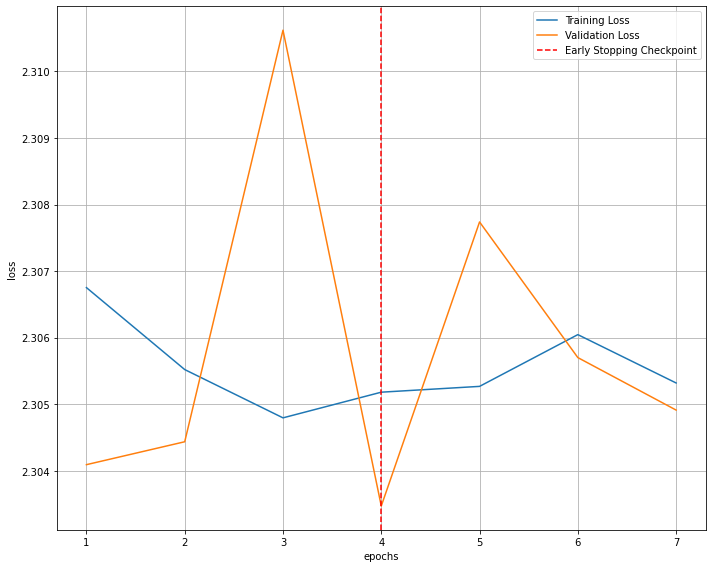

In [50]:
# Testing the train loop

from model_utils import Network
model = Network()

model, train_loss, valid_loss = train(model, 0.1, 
                                              num_epoch, train_loader, 
                                              valid_loader, patience)

In [16]:
best_accuracy = 0.0
best_model_path = './best_model.pth'

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_conv_layers,
            num_fc_units, dropout_rate):

    print('\n\nlearning rate: {0:.1e}'.format(learning_rate))
    print('num_conv_layers:', num_conv_layers)
    print('num_fc_units:', num_fc_units)
    print('dropout_rate:', dropout_rate)
    
    model = MNISTConvNet(num_conv_layers=num_conv_layers,
                         num_fc_units=num_fc_units,
                         dropout_rate=dropout_rate)

    eval_score = score(model, train_loader, 100)
    print('\n', eval_score)
    
    if eval_score < 2800:
        model, train_loss, valid_loss = train(model, learning_rate, 
                                              num_epoch, train_loader, 
                                              valid_loader, patience)
    else:
        return -0.5
    
    accuracy = test(model, test_loader)

    print('Accuracy:', accuracy)

    global best_accuracy

    if accuracy > best_accuracy:
        torch.save(model, best_model_path)
        best_accuracy = accuracy

    del model

    return -accuracy

In [14]:
fitness(x=default_parameters)



learning rate: 1.0e-05
num_conv_layers: 1
num_fc_units: 16
dropout_rate: 0.0001
Array must not contain infs or NaNs
[ 1/10] train_loss: 2.30854 valid_loss: 2.30538
Validation loss decreased (inf --> 2.305378).  Saving model ...
[ 2/10] train_loss: 2.30359 valid_loss: 2.29964
Validation loss decreased (2.305378 --> 2.299637).  Saving model ...
[ 3/10] train_loss: 2.29669 valid_loss: 2.29293
Validation loss decreased (2.299637 --> 2.292929).  Saving model ...
[ 4/10] train_loss: 2.28962 valid_loss: 2.28501
Validation loss decreased (2.292929 --> 2.285006).  Saving model ...
[ 5/10] train_loss: 2.28088 valid_loss: 2.27645
Validation loss decreased (2.285006 --> 2.276446).  Saving model ...
[ 6/10] train_loss: 2.27190 valid_loss: 2.26730
Validation loss decreased (2.276446 --> 2.267300).  Saving model ...
[ 7/10] train_loss: 2.26218 valid_loss: 2.25730
Validation loss decreased (2.267300 --> 2.257304).  Saving model ...
[ 8/10] train_loss: 2.25155 valid_loss: 2.24631
Validation loss decr

-0.15324519230769232

In [18]:
best_accuracy

0.9607371794871795

In [17]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=12,
                            x0=default_parameters)



learning rate: 1.0e-05
num_conv_layers: 1
num_fc_units: 16
dropout_rate: 0.0001
[1/1] train_loss: 2.31801 valid_loss: 2.31462
Validation loss decreased (inf --> 2.314619).  Saving model ...
Test Loss: 2.308893

Accuracy: 0.125


learning rate: 5.2e-04
num_conv_layers: 3
num_fc_units: 87
dropout_rate: 5.4741823222945104e-05
Array must not contain infs or NaNs
[1/1] train_loss: 2.22307 valid_loss: 1.87772
Validation loss decreased (inf --> 1.877724).  Saving model ...
Test Loss: 1.879266

Accuracy: 0.3411458333333333


learning rate: 5.3e-04
num_conv_layers: 3
num_fc_units: 336
dropout_rate: 0.00014373581195837448
Array must not contain infs or NaNs
Array must not contain infs or NaNs
Array must not contain infs or NaNs
[1/1] train_loss: 1.66624 valid_loss: 0.92006
Validation loss decreased (inf --> 0.920063).  Saving model ...
Test Loss: 0.882851

Accuracy: 0.7074318910256411


learning rate: 1.0e-02
num_conv_layers: 2
num_fc_units: 493
dropout_rate: 0.00022836403913351807
Array must 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

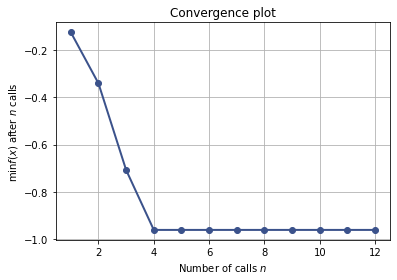

In [19]:
plot_convergence(search_result)

In [12]:
search_result.x

[0.01, 1, 371, 0.0020373556352574866]

In [17]:
space = search_result.space

In [15]:
type(search_result)

scipy.optimize.optimize.OptimizeResult

In [19]:
search_result.fun

-0.9585

In [20]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.9585, [0.01, 1, 371, 0.0020373556352574866]),
 (-0.958, [0.0055907118261023046, 2, 223, 4.235958405745658e-05]),
 (-0.9404, [0.0008260939303352365, 2, 488, 0.0018843111126491078]),
 (-0.6568, [0.0005430212117300351, 3, 52, 0.0008905592246977513]),
 (-0.5447, [8.071479225631815e-06, 1, 171, 0.0006862299423554364]),
 (-0.4914, [2.543226725130005e-05, 2, 125, 0.001796085286350762]),
 (-0.272, [1.2005457717148208e-05, 2, 313, 2.8391575704721965e-05]),
 (-0.1622, [1e-05, 1, 16, 0.0001]),
 (-0.1149, [1.0596205281241633e-06, 2, 322, 9.769567507373085e-05]),
 (-0.1082, [1.0054745084854189e-05, 1, 15, 8.107826584332653e-05]),
 (-0.1041, [2.4882391096055274e-06, 2, 300, 4.438258157420633e-05]),
 (-0.0997, [3.892043891201965e-06, 3, 444, 0.00033865735008855403])]

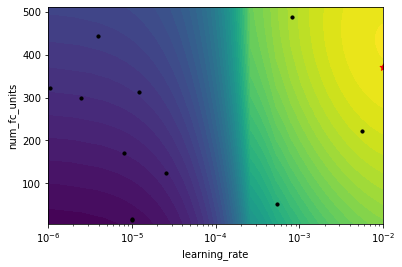

In [22]:
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_fc_units',
                        levels=50)

In [11]:
model = torch.load(best_model_path)
model.eval()

MNISTConvNet(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.0001, inplace=False)
  (fc1): Linear(in_features=507, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [12]:
# MNISTConvNet Model with MNIST

for i in range(5):
    print(score(model, train_loader, 100))

-2925.0997543506764


C:\Users\kaies\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\kaies\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Array must not contain infs or NaNs
-2802.6805185941557
-2886.730985271284
-2894.68595056219
-3320.235352043034
